In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
device = torch.device("cuda", 0)

In [2]:
import numpy as np
import scipy
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
NOISE_DIM = 1
def sample_noise(N):
    return np.random.uniform(size=(N,NOISE_DIM)).astype(np.float32)

In [241]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=150, input_param=1):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim + input_param, hidden_dim)
#         self.bn2 = nn.BatchNorm1d(hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim + input_param, hidden_dim)
#         self.bn3 = nn.BatchNorm1d(hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        # heads
        self.fc_head_11 = nn.Linear(hidden_dim + input_param, hidden_dim//2)
#         self.bn_head_1 = nn.BatchNorm1d(hidden_dim//2)
        nn.init.xavier_normal_(self.fc_head_11.weight)
        nn.init.constant_(self.fc_head_11.bias, 0.0)
        
        self.fc_head_12 = nn.Linear(hidden_dim//2, out_dim)
        nn.init.xavier_normal_(self.fc_head_12.weight)
        nn.init.constant_(self.fc_head_12.bias, 0.0)
        
        # heads
        self.fc_head_21 = nn.Linear(hidden_dim + input_param, hidden_dim//2)
#         self.bn_head_2 = nn.BatchNorm1d(hidden_dim//2)
        nn.init.xavier_normal_(self.fc_head_21.weight)
        nn.init.constant_(self.fc_head_21.bias, 0.0)
        
        self.fc_head_22 = nn.Linear(hidden_dim//2, out_dim)
        nn.init.xavier_normal_(self.fc_head_22.weight)
        nn.init.constant_(self.fc_head_22.bias, 0.0)

    def forward(self, z, params, mode):
        """
            Generator takes a vector of noise and produces sample
        """
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = torch.tanh(self.fc2(torch.cat([h1, params], dim=1)))
        h3 = torch.tanh(self.fc3(torch.cat([h2, params], dim=1)))
        y_gen = torch.tanh(self.fc_head_11(torch.cat([h3, params], dim=1))) if mode=="01" else torch.tanh(self.fc_head_21(torch.cat([h3, params], dim=1)))
        y_gen = self.fc_head_12(y_gen) if mode=="01" else self.fc_head_22(y_gen)
        return y_gen

In [242]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=150, input_param=1):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim + input_param, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim + input_param, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim + input_param, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x, params):
        #x = torch.cat([x, params.repeat(x.shape[0], 1)], dim=1)
        x = torch.cat([x, params], dim=1)
        h1 = torch.tanh(self.bn1(self.fc1(x)))
        h2 = torch.tanh(self.bn2(self.fc2(torch.cat([h1, params], dim=1))))
        h3 = F.leaky_relu(self.bn3(self.fc3(torch.cat([h2, params], dim=1))))
#         score = torch.sigmoid(self.fc4(torch.cat([h3, params], dim=1)))
        score = torch.sigmoid(self.fc4(h3))
        return score

In [249]:
generator = Generator(NOISE_DIM, out_dim = 1).to(device)
discriminator = Discriminator(in_dim = 1).to(device)

lr = 0.00001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [211]:
def g_loss(discrim_output):
    loss = - discrim_output.mean()
    return loss


def d_loss(discrim_output_gen, discrim_output_real):
    loss = - (discrim_output_real.mean() - discrim_output_gen.mean())
    return loss

In [7]:
# # alphas, digits from normal distbution for alpha \in [0,1]
alpha_01 = np.load("alpha_01_1dim.npy")
data_01 = np.load("data_01_1dim.npy")

# # alphas, digits from normal distbution for alpha \in [0,2]
alpha_02 = np.load("alpha_02_1dim.npy")
data_02 = np.load("data_02_1dim.npy")

# # alphas, digits from normal distbution for alpha \in [1,2]
alpha_12 = np.load("alpha_12_1dim.npy")
data_12 = np.load("data_12_1dim.npy")

In [19]:
np.repeat(alpha_01, 1024, axis=1).reshape(-1, 1).shape, data_01.shape

((10240000, 1), (10000, 1024, 1))

In [20]:
from sklearn.model_selection import train_test_split



In [71]:
def prepare_data(alphas, datas, split=False, batch_size=64, val_batch_size=1024):
    """
    makes batches of data to feed the model
    """
    x = np.random.permutation(len(alphas))
    alphas = alphas[x]
    datas = datas[x]
    
    if not split:
        split = 0
    elif 0 <= split <= 1:
        size = len(batch_alpha)
        split = int(split*size)
    
    batch_alpha = []
    batch_data = []
    for i, alpha in enumerate(alphas[split:]):
        for j in range(datas.shape[1]//batch_size):
            batch_alpha.append([alpha]*batch_size)
            batch_data.append(datas[i][j*batch_size:(j+1)*batch_size])
    
    val_batch_alpha = []
    val_batch_data = []
    for i, alpha in enumerate(alphas[:split]):
        for j in range(datas.shape[1]//val_batch_size):
            val_batch_alpha.append([alpha]*val_batch_size)
            val_batch_data.append(datas[i][j*val_batch_size:(j+1)*val_batch_size])
            
    return np.array(batch_alpha), np.array(batch_data), np.array(val_batch_alpha), np.array(val_batch_data)
        

In [72]:
# make batches of data for alpha \in [0, 1]
batch_alpha_01, batch_data_01, valid_alpha_01, valid_data_01 = prepare_data(alpha_01, data_01, batch_size=128, split=100)
# make batches of data for alpha \in [0, 2]
batch_alpha_02, batch_data_02, valid_alpha_02, valid_data_02 = prepare_data(alpha_02, data_02, batch_size=128, split=100)
# make batches of data for alpha \in [1, 2] (validation data)
batch_alpha_12, batch_data_12, _, _ = prepare_data(alpha_02, data_02, batch_size=1024)

In [44]:
# # make batches of data for alpha \in [0, 1]
# batch_data_01, valid_data_01, batch_alpha_01, valid_alpha_01  = train_test_split(data_01.reshape(-1, 1), np.repeat(alpha_01, 1024, axis=1).reshape(-1, 1), test_size=0.05)
# batch_data_02, valid_data_02, batch_alpha_02, valid_alpha_02  = train_test_split(data_02.reshape(-1, 1), np.repeat(alpha_02, 1024, axis=1).reshape(-1, 1), test_size=0.05)
# batch_data_12, valid_data_12, batch_alpha_12, valid_alpha_12  = train_test_split(data_12.reshape(-1, 1), np.repeat(alpha_12, 1024, axis=1).reshape(-1, 1), test_size=0.05)

In [73]:
batch_alpha_01.shape, valid_data_01.shape

((79200, 128, 1), (100, 1024, 1))

In [74]:
def iterate_minibatches(batch_alpha, batch_data):
    rp = np.random.permutation(len(batch_alpha))
    for x, y in zip(batch_alpha[rp], batch_data[rp]):
        yield torch.Tensor(x.reshape((len(x), 1))).to(device), torch.Tensor(y).to(device)

# def iterate_minibatches(batch_alpha, batch_data, batch_size=128):
#     rp = np.random.permutation(len(batch_alpha))
#     batch_alpha = batch_alpha[rp]
#     batch_data = batch_data[rp]
#     for i in range(0, len(batch_alpha), batch_size):
#         yield torch.Tensor(batch_alpha[i: i+batch_size]).to(device), torch.Tensor(batch_data[i: i+batch_size]).to(device)

In [75]:
fixed_noise = torch.Tensor(sample_noise(10000)).to(device)

In [ ]:
valid_alpha_01

In [212]:
from torch import autograd
LAMBDA = 10
def calc_gradient_penalty(real_data, fake_data, input_alpha):
    alpha = torch.rand(real_data.shape[0], 1).expand(real_data.size()).to(device)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = discriminator(interpolates.to(device), input_alpha.to(device))

    gradients = autograd.grad(outputs=disc_interpolates.to(device), inputs=interpolates.to(device),
                              grad_outputs=torch.ones(
                                  disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

In [250]:
from IPython import display
num_epochs = 20


def update_gen(input_alpha, input_data, mode, k_g):
    for _ in range(k_g):
        # Sample noise
        noise = torch.Tensor(sample_noise(len(input_data))).to(device)

        # Do an update
        data_gen = generator(noise, input_alpha, mode=mode)
        loss = g_loss(discriminator(data_gen, input_alpha))
        g_optimizer.zero_grad()
        loss.backward()
        g_optimizer.step()
        
    return loss.item()
    
def update_disc(input_alpha, input_data, mode, k_d):
    for _ in range(k_d):
        # Sample noise
        noise = torch.Tensor(sample_noise(len(input_data))).to(device)

        # Do an update
        inp_data = input_data.to(device)
        data_gen = generator(noise, input_alpha, mode=mode)

        loss = d_loss(discriminator(data_gen, input_alpha), discriminator(inp_data, input_alpha))
#         grad_penalty = calc_gradient_penalty(data_gen.data, inp_data.data, input_alpha)
#         loss += grad_penalty

        d_optimizer.zero_grad()
        loss.backward()
        d_optimizer.step()
                           
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

    return loss.item()


def run_training():
    k_d, k_g = 4, 1

    dis_losses, gen_losses = {"01": [], "02": [], "12": []}, {"01": [], "02": [], "12": []}
    wasserstein_ds = {"01": [], "02": [], "12": []}

    try:
        for epoch in range(num_epochs):
            dis_epoch_loss = {"01": [], "02": [], "12": []}
            gen_epoch_loss = {"01": [], "02": [], "12": []}
            
            train_gen_01 = iterate_minibatches(batch_alpha_01, batch_data_01)
            train_gen_02 = iterate_minibatches(batch_alpha_02, batch_data_02)
                        
            num_iter = 0
            while True:
                num_iter += 1
                try:
                    input_alpha, input_data = next(train_gen_01)
                except StopIteration:
                    break
                    
                # Optimize D
                dis_epoch_loss["01"].append(update_disc(input_alpha, input_data, "01", k_d))

                # Optimize G
                gen_epoch_loss["01"].append(update_gen(input_alpha, input_data, "01", k_g))
                
                try:
                    input_alpha, input_data = next(train_gen_02)
                except StopIteration:
                    break
                    
                # Optimize D
                dis_epoch_loss["02"].append(update_disc(input_alpha, input_data, "02", k_d))

                # Optimize G
                gen_epoch_loss["02"].append(update_gen(input_alpha, input_data, "02", k_g))
                
                
                if num_iter % 100 == 0:
                    
                    ws = []
                    for alpha, batch in zip(valid_alpha_01[:100], valid_data_01[:100]):
                        bs = len(alpha)
                        alpha = torch.Tensor(alpha).to(device)
                        noise = torch.Tensor(sample_noise(bs)).to(device)
                        generated = generator(noise, alpha, mode="01").detach().cpu().numpy()
                        ws.append(scipy.stats.wasserstein_distance(np.squeeze(generated), np.squeeze(batch)))
                    wasserstein_ds["01"].append(np.mean(ws))
                    
                    ws = []
                    for alpha, batch in zip(valid_alpha_02[:100], valid_data_02[:100]):
                        bs = len(alpha)
                        alpha = torch.Tensor(alpha).to(device)
                        noise = torch.Tensor(sample_noise(bs)).to(device)
                        generated = generator(noise, alpha, mode="02").detach().cpu().numpy()
                        ws.append(scipy.stats.wasserstein_distance(np.squeeze(generated), np.squeeze(batch)))
                    wasserstein_ds["02"].append(np.mean(ws))
                    
                    for i in dis_losses:
                        dis_losses[i].append(np.mean(dis_epoch_loss[i]))
                    for i in gen_losses:
                        gen_losses[i].append(np.mean(gen_epoch_loss[i]))
                    # Visualize
                    f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
                    ax1.set_title("Epoch {}".format(epoch))
                    alphas = torch.Tensor([np.random.uniform(0, 1)]*len(fixed_noise)).to(device).reshape(-1, 1)
                    data = np.random.normal(alphas[0].detach().cpu().numpy(), 1, len(fixed_noise))
                    generated = generator(fixed_noise, alphas, mode="01").detach().cpu().numpy()
                    #wasserstein_ds["01"].append(scipy.stats.wasserstein_distance(np.squeeze(generated), data))
                    ax1.hist(data, bins=100, normed=True, label='true');
                    ax1.hist(generated, bins=100, color='g', normed=True, alpha=0.5, label='gan');
                    ax1.grid()
                    ax1.legend()

                    ax2.set_title("Epoch {}".format(epoch))
                    alphas = torch.Tensor([np.random.uniform(0, 2)]*len(fixed_noise)).to(device).reshape(-1, 1)
                    data = np.random.normal(alphas[0].detach().cpu().numpy(), 1, len(fixed_noise))
                    generated = generator(fixed_noise, alphas, mode="02").detach().cpu().numpy()
                    #wasserstein_ds["02"].append(scipy.stats.wasserstein_distance(np.squeeze(generated), data))
                    ax2.hist(data, bins=100, normed=True, label='true');
                    ax2.hist(generated, bins=100, color='g', normed=True, alpha=0.5, label='gan');
                    ax2.grid()
                    ax2.legend()

                    f2, (ax3, ax5) = plt.subplots(1, 2, figsize=(16, 6))
                    ax3.plot(dis_losses["01"], label='d_loss_01', c='b')
                    ax3.plot(dis_losses["02"], label='d_loss_02', c='g')
                    ax3.set_title("epoch")
                    ax3.set_title("loss")
                    ax3.grid()
                    ax3.legend()

                    ax4 = ax3.twinx()
                    ax4.plot(gen_losses["01"], label='g_loss_01', c='r')
                    ax4.plot(gen_losses["02"], label='g_loss_02', c='y')
                    ax3.set_title("epoch")
                    ax3.set_title("loss")
                    ax4.grid()
                    ax4.legend()
                    
                    ax5.plot(wasserstein_ds["01"], label='d_loss_01', c='b')
                    ax5.plot(wasserstein_ds["02"], label='d_loss_02', c='g')
                    ax5.set_title("epoch")
                    ax5.set_title("wasserstein_distance")
                    ax5.grid()
                    ax5.legend()


                    display.clear_output(wait=True)
                    plt.show()


    except KeyboardInterrupt:
        pass

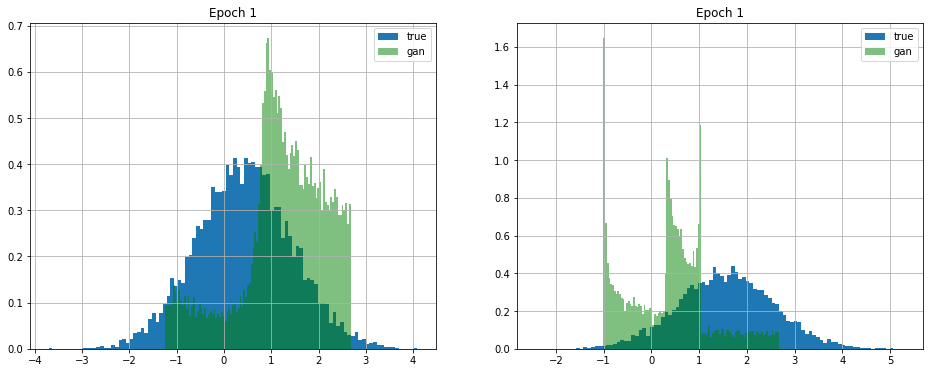

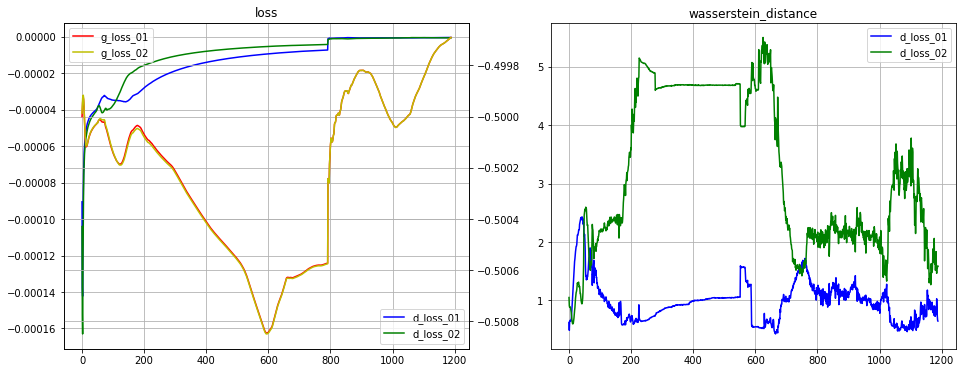

In [251]:
run_training()